<a href="https://colab.research.google.com/github/andrewmsilva/DataScienceStudies/blob/master/Sentiment%20analysis%20of%20IMDB%20reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
The purpose of this notebook is to make sentiment analysis of a list of fifty thousand movie reviews sourced from IMDB. This dataset can be found in [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data).

# Steps
* [Data loading](#Data-loading)
* [Data pre-processing](#Data-pre-processing)
* [Data visualization](#Data-visualization)
* [Features extraction](#Features-extraction)
  * [Generate Bag of Words](#Generate-Bag-of-Words)
  * [Generate TF-IDF](#Generate-TF-IDF)
* [Models training](#Models-training)
  * [Using Bag of Words](#Using-Bag-of-Words)
  * [Using TF-IDF](#Using-TF-IDF)
* [Scores evaluation](#Scores-evaluation)


# Data loading

In [124]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Saving kaggle.json to kaggle (2).json
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import pandas as pd

reviews_df = pd.read_csv('imdb-dataset-of-50k-movie-reviews.zip', compression='zip', header=0, sep=',', quotechar='"')

In [0]:
# Displaying
reviews_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# Data pre-processing

In [0]:
import nltk
import string
#nltk.download('stopwords')
#nltk.download('wordnet')

def preProcess(df, feature, new_column=None):
  stop_words = nltk.corpus.stopwords.words()
  punctuation = list(string.punctuation)
  
  tokenizer = nltk.tokenize.WordPunctTokenizer()
  stemmer = nltk.SnowballStemmer('english')
  lemmatizer = nltk.WordNetLemmatizer()

  pre_processed_data = []
  for data in df[feature]:
    data = data.replace('<br />', '')
    data = data.lower()
    
    tokens = tokenizer.tokenize(data)
    data = ''
    for token in tokens:
      if token not in stop_words and token not in punctuation:
        token = stemmer.stem(lemmatizer.lemmatize(token, pos='v'))
        data += token + ' '
    
    pre_processed_data.append(data)
  
  if new_column is None:
    new_column = feature
  df[new_column] = pre_processed_data
  
preProcess(reviews_df, 'review', 'processed_review')

In [0]:
# Displaying
reviews_df

,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,positive,review mention watch 1 oz episod hook right ex...
1,A wonderful little production. <br /><br />The...,positive,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,positive,think wonder way spend time hot summer weekend...
3,Basically there's a family where a little boy ...,negative,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visual stun film...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,think movi right good job creativ origin first...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogu bad act idiot direct anno...
49997,I am a Catholic taught in parochial elementary...,negative,cathol teach parochi elementari school nun tea...
49998,I'm going to have to disagree with the previou...,negative,go disagre previous comment side maltin second...


# Data visualization

In [0]:
def getWords(df, feature, target, target_cut=None):
  if target_cut is not None:
    df = df.query(target + ' == "' + target_cut + '"')
    
  return ' '.join([ word for word in df[feature] ])

unprocessed_words = getWords(reviews_df, 'review', 'sentiment')
processed_words = getWords(reviews_df, 'processed_review', 'sentiment')

## Word Clouds

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
    
def showWordCloud(words):
  word_cloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(words)

  plt.figure(figsize=(14, 7))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

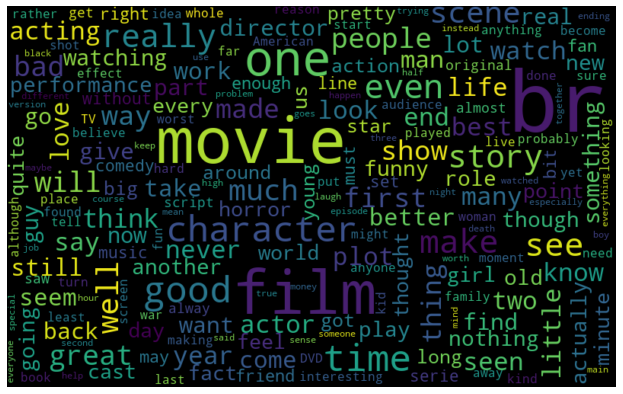

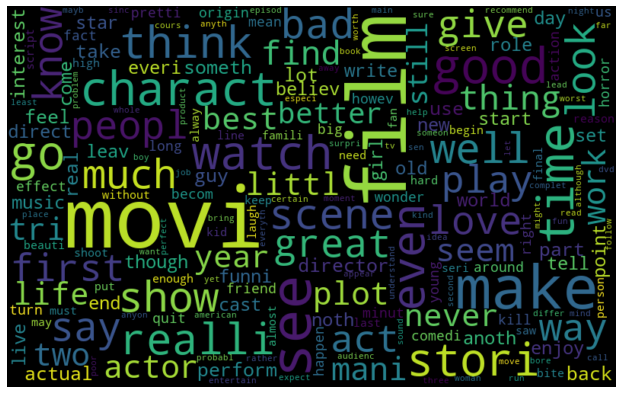

In [0]:
# Displaying
showWordCloud(unprocessed_words)
showWordCloud(processed_words)

## Pareto chart

In [0]:
import seaborn as sns

def getFreqDist(words):
  tokenizer = nltk.tokenize.WordPunctTokenizer()
  tokens = tokenizer.tokenize(words)
  freq = nltk.FreqDist(tokens)
  return pd.DataFrame({'token': list(freq.keys()), 'freq': list(freq.values())})

def showPareto(words, n=None):
  freq_df = getFreqDist(words)
  if n is not None:
    freq_df = freq_df.nlargest(columns='freq', n=n)
  plt.figure(figsize=(10, 7))
  ax = sns.barplot(data=freq_df, x='token', y='freq', color='gray')
  plt.show()

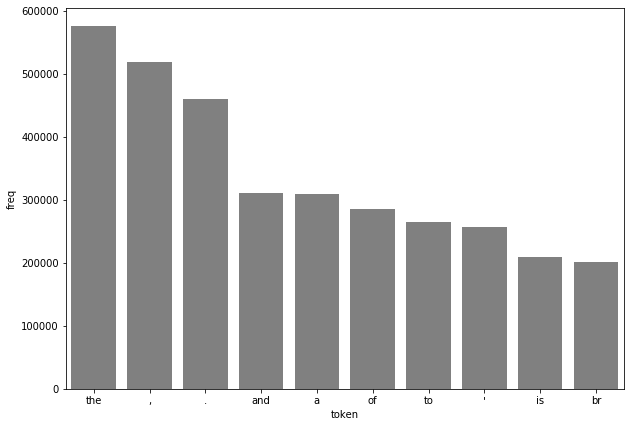

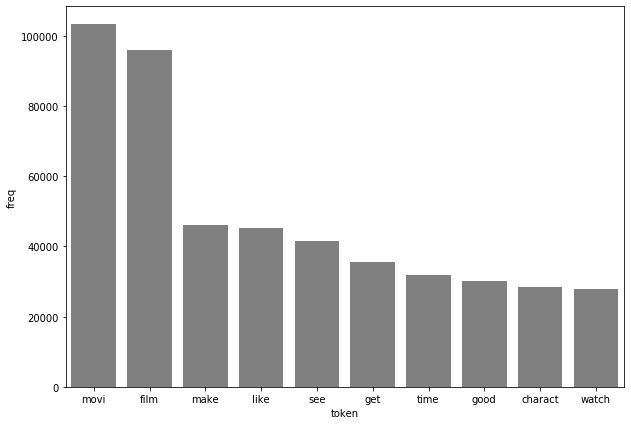

In [0]:
# Displaying
showPareto(unprocessed_words, 10)
showPareto(processed_words, 10)

# Features extraction

## Generate Bag of Words

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(lowercase=False)
unprocessed_bow = count_vectorizer.fit_transform(reviews_df.review)
processed_bow = count_vectorizer.fit_transform(reviews_df.processed_review)

## Generate TF-IDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase=False)
unprocessed_tfidf = vectorizer.fit_transform(reviews_df.review)
processed_tfidf = vectorizer.fit_transform(reviews_df.processed_review)

# Models training

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

options = {
  'random_state': 59,
  'solver': 'lbfgs',
  'max_iter': 10000
}

## Using Bag of Words

In [0]:
unprocessed_bow_train_data, unprocessed_bow_test_data, unprocessed_bow_train_target, unprocessed_bow_test_target = train_test_split(unprocessed_bow, reviews_df.sentiment, random_state = 59)
unprocessed_bow_model = LogisticRegression(**options)
unprocessed_bow_model.fit(unprocessed_bow_train_data, unprocessed_bow_train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=59, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
processed_bow_train_data, processed_bow_test_data, processed_bow_train_target, processed_bow_test_target = train_test_split(processed_bow, reviews_df.sentiment, random_state = 59)
processed_bow_model = LogisticRegression(**options)
processed_bow_model.fit(processed_bow_train_data, processed_bow_train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=59, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Using TF-IDF

In [0]:
unprocessed_tfidf_train_data, unprocessed_tfidf_test_data, unprocessed_tfidf_train_target, unprocessed_tfidf_test_target = train_test_split(unprocessed_tfidf, reviews_df.sentiment, random_state = 59)
unprocessed_tfidf_model = LogisticRegression(**options)
unprocessed_tfidf_model.fit(unprocessed_tfidf_train_data, unprocessed_tfidf_train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=59, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
processed_tfidf_train_data, processed_tfidf_test_data, processed_tfidf_train_target, processed_tfidf_test_target = train_test_split(processed_tfidf, reviews_df.sentiment, random_state = 59)
processed_tfidf_model = LogisticRegression(**options)
processed_tfidf_model.fit(processed_tfidf_train_data, processed_tfidf_train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=59, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Scores evaluation

In [0]:
print('Bag of Words')
print('  Unprocessed data:', unprocessed_bow_model.score(unprocessed_bow_test_data, unprocessed_bow_test_target))
print('  Processed data:', processed_bow_model.score(processed_bow_test_data, processed_bow_test_target))
print('\nTF-IDF')
print("  Unprocessed data:", unprocessed_bow_model.score(unprocessed_tfidf_test_data, unprocessed_tfidf_test_target))
print("  Processed data:", processed_tfidf_model.score(processed_tfidf_test_data, processed_tfidf_test_target))

Bag of Words
  Unprocessed data: 0.88848
  Processed data: 0.87872

TF-IDF
  Unprocessed data: 0.86728
  Processed data: 0.89216
